In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm

In [2]:
# 데이터 로드
df = pd.read_csv('preprocessed_data_ver.2.2.(IRR+LOG+BINARY).csv')

In [3]:
# 모든 열 다 보기
pd.set_option('display.max_columns', None)

# 모든 행 다 보기
pd.set_option('display.max_rows', None)

# 열 너비 넉넉하게
pd.set_option('display.width', None)

# 열 안의 값 자르지 않게
pd.set_option('display.max_colwidth', None)

In [4]:
df.head()

,funded_amnt,term,installment,emp_length,annual_inc,issue_d,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,recoveries,collection_recovery_fee,last_pymnt_d,last_fico_range_high,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,addr_state_nan,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan,emp_length_missing,percent_bc_gt_75_missing,pub_rec_missing,funded_amnt_missing,mths_since_last_delinq_missing,inq_last_6mths_missing,mths_since_recent_revol_delinq_missing,delinq_amnt_missing,fico_range_high_missing,acc_now_delinq_missing,il_util_missing,mths_since_rcnt_il_missing,open_acc_6m_missing,installment_missing,recoveries_missing,open_rv_24m_missing,open_il_12m_missing,open_rv_12m_missing,open_act_il_missing,open_il_24m_missing,fico_range_low_missing,mths_since_recent_inq_missing,collection_recovery_fee_missing,inq_last_12m_missing,delinq_2yrs_missing,max_bal_bc_missing,total_bal_il_missing,last_fico_range_high_missing,annual_inc_missing,total_acc_missing,revol_bal_missing,all_util_missing,open_acc_missing
0,6000.0,36,187.94,2.0,10.714440,2017-12-01,2.269028,1,755.0,759.0,0.0,22.0,14.0,0,8.036250,14.0,36.0,0.00,0.000,Apr-2020,764.0,0,0,0,50054.0,1.0,10.0,3.0,3.0,3.0,46964.0,83.0,1.0,1.0,8.036250,64.0,10.003378,2.0,4.0,8.256088,9.385218,20.6,0,0.0,147.0,135.0,12.0,3.0,1.0,56.0,3.0,0.0,0.0,1.0,1.0,4.0,28.0,4.0,7.0,1.0,14.0,0,0,0,4.0,97.1,0.0,0,0,11.272280,10.820878,9.615872,10.942208,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,23200.0,60,680.82,10.0,11.608245,2016-07-01,3.575151,1,670.0,674.0,1.0,10.0,24.0,0,9.735660,55.9,60.0,5260.00,946.800,Dec-2016,639.0,0,0,0,606327.0,1.0,10.0,1.0,2.0,10.0,277552.0,90.0,4.0,6.0,8.455105,85.0,10.317450,7.0,8.0,10.137175,8.702012,70.4,0,0.0,126.0,277.0,6.0,6.0,2.0,7.0,0.0,10.0,0.0,10.0,8.0,14.0,36.0,12.0,22.0,10.0,24.0,0,0,0,5.0,94.8,37.5,0,0,13.386134,12.592905,9.918425,12.582679,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [5]:
# 독립변수에서 제외할 변수 목록
drop_cols = [
    'term', 'last_pymnt_d', 'installment', 'funded_amnt',
    'recoveries', 'collection_recovery_fee', 'default', 'issue_d'
]

X = df.drop(columns=drop_cols)
y = df['default']

# 원본 데이터 보존
original = df.copy()


# Train-test-split
# 먼저 test 데이터 분리 (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
original_temp, original_test = train_test_split(
    original, test_size=0.2, random_state=42, stratify=original['default']
)

# 남은 80% 중에서 train (60%) / val (20%) 분리
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)
original_train, original_val = train_test_split(
    original_temp, test_size=0.25, random_state=42, stratify=original_temp['default']
)

In [5]:
from fredapi import Fred

# FRED API 연결
fred = Fred(api_key="f9ef939a9a1eeff85d31ed2c984507d9")  # 🔑 실제 API 키로 대체해야 함

# 미국 3년 만기 국채 수익률(GS3) 시계열 불러오기
series = fred.get_series('GS3')  # pandas.Series 형식으로 반환됨


print(series.tail())

2025-03-01    3.96
2025-04-01    3.78
2025-05-01    3.90
2025-06-01    3.86
2025-07-01    3.84
dtype: float64


In [ ]:
def get_nearest_rate(issue_date, rate_series):
    if pd.isnull(issue_date):
        return np.nan
    try:
        idx = rate_series.index.get_indexer([issue_date], method='nearest')[0]
        return rate_series.iloc[idx] / 100  # % 단위 → 소수로 변환
    except Exception as e:
        print(f"Error: {issue_date} ▶ {e}")
        return np.nan


df['risk_free_rate'] = df['issue_d'].apply(lambda x: get_nearest_rate(x, series))

In [8]:
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'])
df['issue_d'] = pd.to_datetime(df['issue_d'])  # 혹시 모르니 이것도

/var/folders/r6/y99jmfln47q2t97qj84_3n080000gn/T/ipykernel_28590/4242469769.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'])


In [9]:
print(df[['issue_d', 'risk_free_rate', 'last_pymnt_d']].head())

     issue_d  risk_free_rate last_pymnt_d
0 2017-12-01          0.0196   2020-04-01
1 2016-07-01          0.0079   2016-12-01
2 2017-10-01          0.0168   2019-08-01
3 2017-05-01          0.0148   2019-03-01
4 2015-09-01          0.0101   2018-10-01


In [10]:
from dateutil.relativedelta import relativedelta
import numpy as np

def create_cash_flow_from_dates(row):
    try:
        term = int(row['term'])
        default = int(row['default'])
        issue_d = row['issue_d']  # 이미 datetime 형식
        last_pymnt_d = pd.to_datetime(row['last_pymnt_d'])  # 이건 문자열일 수도 있으니 변환
        installment = float(row['installment'])
        funded_amnt = float(row['funded_amnt'])
        recoveries = float(row['recoveries'])
        collection_fee = float(row['collection_recovery_fee'])

        # 첫 현금흐름: 대출 실행
        cash_flow = [-funded_amnt]

        if pd.isnull(issue_d) or pd.isnull(last_pymnt_d):
            return np.nan

        # 몇 회차까지 납입했는지 계산
        delta = relativedelta(last_pymnt_d, issue_d)
        last_pymnt_num = delta.years * 12 + delta.months

        for month in range(1, term + 1):
            if default == 1:
                if month <= last_pymnt_num:
                    cash_flow.append(installment)
                elif month == last_pymnt_num + 1:
                    cash_flow.append(recoveries - collection_fee)
                else:
                    cash_flow.append(0)
            else:
                cash_flow.append(installment)

        return cash_flow

    except Exception as e:
        print(f"[오류] index={row.name}, error={e}")
        return np.nan


In [11]:
df['cash_flow'] = df.apply(create_cash_flow_from_dates, axis=1)

In [19]:
!pip install numpy-financial


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [12]:
import numpy_financial as npf

def get_irr(cash_flow):
    if not isinstance(cash_flow, list) or len(cash_flow) == 0:
        return np.nan
    irr_monthly = npf.irr(cash_flow)
    if irr_monthly is None or np.isnan(irr_monthly):
        return np.nan
    return (1 + irr_monthly) ** 12 - 1  # 연환산

In [13]:
df['irr'] = df['cash_flow'].apply(get_irr)

In [14]:
df['irr'] = df['irr'].fillna(df['risk_free_rate'])

df['irr'] = df['cash_flow'].apply(lambda x: np.irr(x) if isinstance(x, list) else np.nan)




---



In [15]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Sharpe 계산 함수
def calculate_sharpe(returns, risk_free_rates):
    excess = returns - risk_free_rates
    if excess.std(ddof=1) == 0:
        return -np.inf
    return excess.mean() / excess.std(ddof=1)

# 랜덤 포레스트 모델 학습 (기본 하이퍼파라미터)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 검증 세트에 대한 부도 확률 예측
y_pred_proba = model.predict_proba(X_val)[:, 1]

# 사용할 threshold 후보들
thresholds = np.arange(0.0, 0.95, 0.05)

best_sharpe = -np.inf
best_threshold = None

# X_val의 인덱스를 이용해 df에서 대응하는 행 추출
val_indices = X_val.index
df_val = df.loc[val_indices]

for threshold in thresholds:
    approved_mask = y_pred_proba <= threshold
    denied_mask = ~approved_mask

    selected = df_val.copy()

    # 승인된 건: 실제 IRR 사용
    selected.loc[approved_mask, 'irr_adj'] = selected.loc[approved_mask, 'irr']

    # 거절된 건: IRR을 국채수익률로 설정
    selected.loc[denied_mask, 'irr_adj'] = selected.loc[denied_mask, 'risk_free_rate']

    # 수익률과 무위험수익률 추출
    returns = selected['irr_adj']
    risk_free = selected['risk_free_rate']

    # NaN 제거
    valid = returns.notnull() & risk_free.notnull()
    if valid.sum() < 2:
        continue

    sharpe = calculate_sharpe(returns[valid], risk_free[valid])

    if sharpe > best_sharpe:
        best_sharpe = sharpe
        best_threshold = threshold

print(f"Best threshold: {best_threshold}")
print(f"Best Sharpe Ratio: {best_sharpe:.4f}")


Best threshold: 0.1
Best Sharpe Ratio: 0.6121


In [18]:
for t in thresholds:
    approved = (y_pred_proba <= t)
    print(f"Threshold={t:.2f} → 승인율={approved.mean():.3f}")


Threshold=0.00 → 승인율=0.021
Threshold=0.05 → 승인율=0.345
Threshold=0.10 → 승인율=0.582
Threshold=0.15 → 승인율=0.675
Threshold=0.20 → 승인율=0.712
Threshold=0.25 → 승인율=0.732
Threshold=0.30 → 승인율=0.746
Threshold=0.35 → 승인율=0.761
Threshold=0.40 → 승인율=0.779
Threshold=0.45 → 승인율=0.801
Threshold=0.50 → 승인율=0.829
Threshold=0.55 → 승인율=0.861
Threshold=0.60 → 승인율=0.895
Threshold=0.65 → 승인율=0.929
Threshold=0.70 → 승인율=0.960
Threshold=0.75 → 승인율=0.984
Threshold=0.80 → 승인율=0.996
Threshold=0.85 → 승인율=1.000
Threshold=0.90 → 승인율=1.000


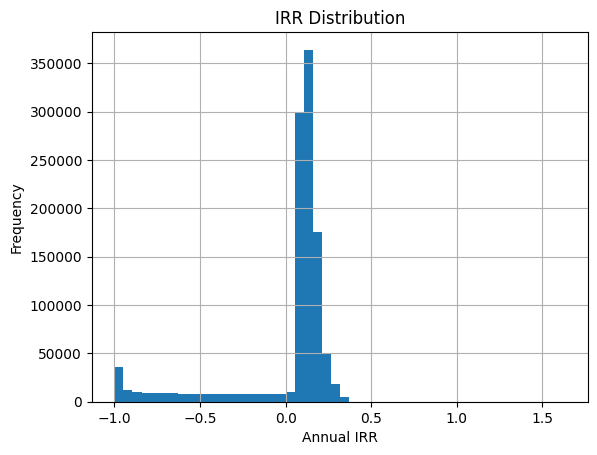

In [19]:
import matplotlib.pyplot as plt
df['irr'].hist(bins=50)
plt.title("IRR Distribution")
plt.xlabel("Annual IRR")
plt.ylabel("Frequency")
plt.show()


In [20]:
# 테스트 세트에 대한 부도 확률 예측
y_test_pred_proba = model.predict_proba(X_test)[:, 1]

# threshold 이하만 승인
test_approved_mask = y_test_pred_proba <= best_threshold

# X_test의 인덱스를 통해 df에서 대상 데이터 추출
df_test = df.loc[X_test.index]
test_selected = df_test[test_approved_mask]

# IRR과 risk_free_rate 사용
returns_test = test_selected['irr']
risk_free_test = test_selected['risk_free_rate']

# 유효 데이터만 선택
valid = returns_test.notnull() & risk_free_test.notnull()
returns_test = returns_test[valid]
risk_free_test = risk_free_test[valid]

# Sharpe 계산
sharpe_test = calculate_sharpe(returns_test, risk_free_test)

print(f"Test Set - 승인 수: {len(returns_test)}")
print(f"Test Set - 승인율: {len(returns_test) / len(df_test):.2%}")
print(f"Test Set - 평균 IRR: {returns_test.mean():.4f}")
print(f"Test Set - IRR > 0 비율: {(returns_test > 0).mean():.2%}")
print(f"Test Set - Sharpe Ratio: {sharpe_test:.4f}")


Test Set - 승인 수: 130146
Test Set - 승인율: 58.30%
Test Set - 평균 IRR: 0.1152
Test Set - IRR > 0 비율: 98.48%
Test Set - Sharpe Ratio: 0.9116
